# Parte 3: Entrenamiento de clasificadores

1. Darwin Yusef Gonzalez 
2. Orlando Silva 
3. Jose Barrios
4. Ana Hernandez
June 2025

In [ ]:
# 🤓 Iniciamos con la configuración y extracción de las librerías senseval, punk stopwords wordnet,
import os
import nltk
from nltk.corpus import senseval
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string
from collections import Counter
import re
import string

nltk.download('senseval') # Para el corpus Senseval 2
nltk.download('punkt')    # Para tokenización
nltk.download('stopwords') # Para palabras vacías (stop words)
nltk.download('wordnet')  # Aunque no se use directamente para los sentidos, es útil para entender WordNet.
nltk.download('averaged_perceptron_tagger') # Para etiquetado POS si se necesita, aunque Senseval ya viene con ello.

[nltk_data] Downloading package senseval to C:\Users\Aqui
[nltk_data]     Creamos\AppData\Roaming\nltk_data...
[nltk_data]   Package senseval is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Aqui
[nltk_data]     Creamos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Aqui
[nltk_data]     Creamos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Aqui
[nltk_data]     Creamos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Aqui Creamos\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
try:
    nltk.data.find('corpora/senseval')
except nltk.downloader.DownloadError:
    nltk.download('senseval')
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

In [ ]:
import nltk
from nltk.corpus import stopwords, senseval
from nltk.classify import NaiveBayesClassifier, accuracy
import string
from collections import Counter
import random

# --- REUSO DE CÓDIGO DE LAS PARTES ANTERIORES ---

# Clase dummy para simular las instancias del corpus (si senseval.instances() no la tiene directamente)
# Senseval ya retorna objetos con 'context' y 'word' atributos, así que no es estrictamente necesaria aquí
# pero la mantengo por si la estructura de tus datos previos era diferente.
class CustomInstance:
    def __init__(self, context, ambiguous_word, sense):
        self.context = context
        self.ambiguous_word = ambiguous_word
        self.sense = sense # El sentido real de la palabra, para el etiquetado

# Tu conjunto de palabras a eliminar (igual al anterior)
OTHER_WORDS = ["''", "'d", "'ll", "'m", "'re", "'s", "'t", "'ve", '--', '000', '1', '2', '3', '4', '5', '6', '8', '10', '15', '30', 'I', 'F', '``',
               'also', "don'", 'n', 'one', 'said', 'say', 'says', 'u', 'us']

# Conjunto combinado de stopwords de NLTK (inglés), puntuación y tus palabras adicionales
STOPWORDS_SET = set(stopwords.words('english')).union(set(string.punctuation), set(OTHER_WORDS))

# Formas gramaticales de la palabra ambigua 'hard'
# (Identificadas en la Parte 1 - debes asegurarte de que sean correctas para tu corpus específico)
PALABRA_AMBIGUA_HARD_FORMS = {'hard', 'harder', 'hardest'}
PALABRAS_AMBIGUAS_FORMS = {
    'hard': PALABRA_AMBIGUA_HARD_FORMS,
    # 'serve': {'serve', 'serves', 'served', 'serving'} # Agrega 'serve' si también la vas a desambiguar
}

def construir_vocabulario(instances, m, palabras_a_excluir):
    """
    Construye un vocabulario de las 'm' palabras más frecuentes del corpus,
    excluyendo puntuación, stopwords y formas gramaticales de las palabras ambiguas.

    Args:
        instances (list): Lista de objetos Instance (o de Senseval Instance)
                          cada uno con un atributo 'context' (lista de (palabra, tag) tuples).
        m (int): El número de palabras más frecuentes a incluir en el vocabulario.
        palabras_a_excluir (set): Conjunto de palabras a excluir del vocabulario
                                  (incluye stopwords, puntuación y formas de la ambigua).

    Returns:
        list: El vocabulario construido (lista de palabras).
    """
    all_words = []
    for instance in instances:
        # instance.context en Senseval 2 es una lista de tuplas (palabra, tag)
        # MODIFICACIÓN PARA RESOLVER EL ERROR:
        for item in instance.context: # Iterar sobre cada item en el contexto
            word_to_process = ''
            if isinstance(item, tuple):
                word_to_process = item[0] # Si es una tupla (word, tag), toma la palabra
            elif isinstance(item, str):
                word_to_process = item # Si es una cadena, úsala directamente
            
            if word_to_process: # Asegurarse de que no esté vacío
                word_lower = word_to_process.lower()
                all_words.append(word_lower)
            
    fdist = nltk.FreqDist(all_words)
    
    filtered_words_freq = Counter()
    for word, freq in fdist.items():
        if word not in palabras_a_excluir:
            filtered_words_freq[word] = freq
            
    vocabulario = [word for word, freq in filtered_words_freq.most_common(m)]
    
    return vocabulario

def extraer_caracteristicas_diccionario(instance_context, vocabulario):
    """
    Extrae un diccionario de características binarias basado en la presencia
    de palabras del vocabulario en el contexto dado.

    Args:
        instance_context (list): Una lista de (palabra, tag) tuplas que forman la oración completa.
        vocabulario (list): Una lista de palabras que conforman el vocabulario de características.

    Returns:
        dict: Un diccionario donde la clave es 'contains(palabra)' y el valor es True/False.
    """
    vector_caracteristicas = {}
    contexto_palabras_lower = []

    # Normalizar el contexto a solo palabras en minúsculas
    # MODIFICACIÓN PARA RESOLVER EL ERROR EN ESTA FUNCIÓN TAMBIÉN (si aplica)
    for item in instance_context:
        word_to_add = ''
        if isinstance(item, tuple):
            word_to_add = item[0]
        elif isinstance(item, str):
            word_to_add = item
        
        if word_to_add:
            contexto_palabras_lower.append(word_to_add.lower())

    # Construir el diccionario de características
    for palabra_vocabulario in vocabulario:
        clave = f'contains({palabra_vocabulario})'
        if palabra_vocabulario.lower() in contexto_palabras_lower:
            vector_caracteristicas[clave] = True
        else:
            vector_caracteristicas[clave] = False
            
    return vector_caracteristicas

# --- NUEVA FUNCIÓN: Extracción de características de colocación ---

def extraer_caracteristicas_colocacion(instance_context, ambiguous_word_index, n=2):
    """
    Extrae características de colocación (palabras a n posiciones antes y después
    de la palabra ambigua).

    Args:
        instance_context (list): Lista de (palabra, tag) tuplas que forman la oración completa.
        ambiguous_word_index (int): El índice de la palabra ambigua en el contexto.
        n (int): Número de palabras a considerar antes y después de la palabra ambigua.

    Returns:
        dict: Un diccionario de características de colocación.
    """
    features = {}
    
    # Obtener solo las palabras del contexto, en minúsculas
    # MODIFICACIÓN PARA RESOLVER EL ERROR EN ESTA FUNCIÓN TAMBIÉN (si aplica)
    words = []
    for item in instance_context:
        word_to_add = ''
        if isinstance(item, tuple):
            word_to_add = item[0]
        elif isinstance(item, str):
            word_to_add = item
        if word_to_add:
            words.append(word_to_add.lower())
    
    # Colocaciones a la izquierda
    for i in range(1, n + 1):
        if ambiguous_word_index - i >= 0:
            features[f'L{i}={words[ambiguous_word_index - i]}'] = True
        else:
            features[f'L{i}=<START>'] = True # Marcador de inicio de oración
            
    # Colocaciones a la derecha
    for i in range(1, n + 1):
        if ambiguous_word_index + i < len(words):
            features[f'R{i}={words[ambiguous_word_index + i]}'] = True
        else:
            features[f'R{i}=<END>'] = True # Marcador de fin de oración
            
    return features

# --- PROCESO PRINCIPAL DE ENTRENAMIENTO Y EVALUACIÓN ---

print("--- Desambiguación de la palabra 'hard' ---")

# 1. Cargar las instancias de 'hard' del corpus Senseval 2
# Las instancias de senseval son objetos con 'word' (el LexicalSample), 'context' (list of (word, tag) tuples), 'position' (index of the ambiguous word), 'senses' (list of senses)
hard_instances = senseval.instances('hard.pos')
print(f"Total de instancias para 'hard' cargadas: {len(hard_instances)}")

# 2. Preparar los datos para el entrenamiento y test
# Asegurar que haya instancias de todas las clases en el entrenamiento
senses = set(inst.senses[0] for inst in hard_instances) # Asumiendo un solo sentido por instancia para simplificar
print(f"Sentidos de 'hard' encontrados: {senses}")

# Agrupar instancias por sentido
instances_by_sense = {sense: [] for sense in senses}
for inst in hard_instances:
    # Senseval instances may have multiple senses; take the first one
    if inst.senses:
        instances_by_sense[inst.senses[0]].append(inst)
    # else: # Handle cases where an instance might not have a sense (rare for Senseval)
        # print(f"Warning: Instance without sense found: {inst.context}")

training_set = []
test_set = []

# Dividir 80-20 para cada sentido para asegurar representación
for sense, instances in instances_by_sense.items():
    random.shuffle(instances) # Mezclar instancias de cada sentido
    split_point = int(0.8 * len(instances))
    training_set.extend(instances[:split_point])
    test_set.extend(instances[split_point:])

random.shuffle(training_set) # Mezclar el conjunto de entrenamiento final
random.shuffle(test_set)     # Mezclar el conjunto de prueba final

print(f"Tamaño del conjunto de entrenamiento: {len(training_set)}")
print(f"Tamaño del conjunto de prueba: {len(test_set)}")

# 3. Conjunto de palabras a excluir para la construcción del vocabulario
# Combina stopwords, puntuación y formas de 'hard'
words_to_exclude_for_vocab = set(STOPWORDS_SET).union(PALABRA_AMBIGUA_HARD_FORMS)

# 4. Construir el vocabulario de 250 palabras más frecuentes para el clasificador de palabras vecinas
m_vocab_size = 250
vocabulario_vecinas = construir_vocabulario(training_set, m_vocab_size, words_to_exclude_for_vocab)
print(f"\nVocabulario de palabras vecinas (top {m_vocab_size} palabras):\n{vocabulario_vecinas[:10]}... (mostrando las primeras 10)") # Mostrar solo un fragmento


# --- Clasificador Basado en Palabras Vecinas ---
print("\n--- Clasificador Basado en Palabras Vecinas ---")

# Preparar los conjuntos de datos para el clasificador (featureset)
# Cada elemento es una tupla: (diccionario_de_caracteristicas, sentido_real)
training_featureset_vecinas = [
    (extraer_caracteristicas_diccionario(inst.context, vocabulario_vecinas), inst.senses[0])
    for inst in training_set
]

test_featureset_vecinas = [
    (extraer_caracteristicas_diccionario(inst.context, vocabulario_vecinas), inst.senses[0])
    for inst in test_set
]

# Entrenar el clasificador Naive Bayes
classifier_vecinas = NaiveBayesClassifier.train(training_featureset_vecinas)
print(f"Clasificador de palabras vecinas entrenado.")

# Evaluar el clasificador
accuracy_vecinas = accuracy(classifier_vecinas, test_featureset_vecinas)
print(f"Precisión del clasificador de palabras vecinas: {accuracy_vecinas:.4f}")

# Mostrar las 10 características más informativas (opcional)
print("Características más informativas (palabras vecinas):")
classifier_vecinas.show_most_informative_features(10)


# --- Clasificador Basado en Características de Colocación ---
print("\n--- Clasificador Basado en Colocación ---")

# Preparar los conjuntos de datos para el clasificador (featureset)
# Usar n=2 para 2 palabras antes y 2 después
n_colocacion = 2

training_featureset_colocacion = [
    (extraer_caracteristicas_colocacion(inst.context, inst.position, n_colocacion), inst.senses[0])
    for inst in training_set
]

test_featureset_colocacion = [
    (extraer_caracteristicas_colocacion(inst.context, inst.position, n_colocacion), inst.senses[0])
    for inst in test_set
]

# Entrenar el clasificador Naive Bayes
classifier_colocacion = NaiveBayesClassifier.train(training_featureset_colocacion)
print(f"Clasificador de colocación entrenado.")

# Evaluar el clasificador
accuracy_colocacion = accuracy(classifier_colocacion, test_featureset_colocacion)
print(f"Precisión del clasificador de colocación: {accuracy_colocacion:.4f}")

# Mostrar las 10 características más informativas (opcional)
print("Características más informativas (colocación):")
classifier_colocacion.show_most_informative_features(10)

--- Desambiguación de la palabra 'hard' ---
Total de instancias para 'hard' cargadas: 4333
Sentidos de 'hard' encontrados: {'HARD2', 'HARD1', 'HARD3'}
Tamaño del conjunto de entrenamiento: 3465
Tamaño del conjunto de prueba: 868

Vocabulario de palabras vecinas (top 250 palabras):
['time', 'would', 'get', 'work', 'make', 'find', 'people', 'even', 'like', 'going']... (mostrando las primeras 10)

--- Clasificador Basado en Palabras Vecinas ---
Clasificador de palabras vecinas entrenado.
Precisión del clasificador de palabras vecinas: 0.8422
Características más informativas (palabras vecinas):
Most Informative Features
          contains(soft) = True            HARD3 : HARD1  =    119.4 : 1.0
          contains(rock) = True            HARD3 : HARD1  =     44.5 : 1.0
      contains(feelings) = True            HARD2 : HARD1  =     39.0 : 1.0
          contains(look) = True            HARD2 : HARD1  =     19.2 : 1.0
          contains(work) = True            HARD2 : HARD3  =     17.6 : 1.0
 

--- Desambiguación de la palabra 'hard' ---
Total de instancias para 'hard' cargadas: 4333
Sentidos de 'hard' encontrados: ['HARD1', 'HARD2', 'HARD3']
Tamaño del conjunto de entrenamiento: 3465
Tamaño del conjunto de prueba: 868

Vocabulario de palabras vecinas (top 250 palabras):
['time', 'would', 'work', 'get', 'make', 'find', 'people', 'even', 'like', 'going']... (mostrando las primeras 10)

--- EVALUACIÓN: Clasificador Basado en Palabras Vecinas ---
Clasificador de palabras vecinas entrenado.
Precisión (Accuracy): 0.8399

Matriz de Confusión:
[[674  12   5]
 [ 60  40   1]
 [ 60   1  15]]

Precisión (ponderada): 0.8261
Recall (ponderado): 0.8399
F1-score (ponderado): 0.8102


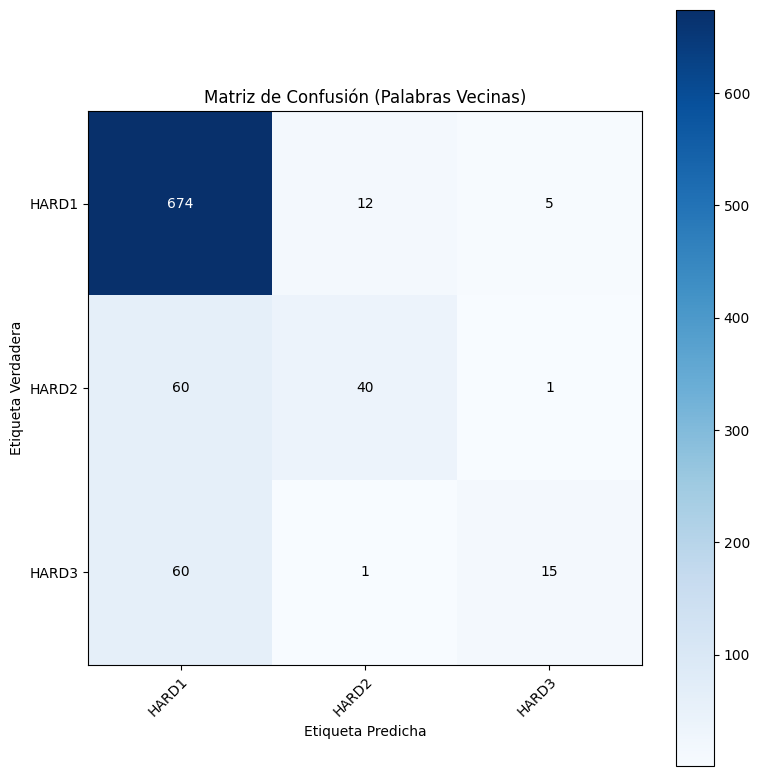


--- Curva ROC y AUC (Multiclase) ---
Nota: NLTK Naive Bayes no expone directamente las probabilidades de cada clase para ROC AUC.
Para una curva ROC completa en multiclase, se necesitaría un clasificador
que devuelva probabilidades por clase (ej., classifier.prob_classify(features).prob(class_label)).
Intentaremos simular un clasificador binario o indicar cuando no sea posible.


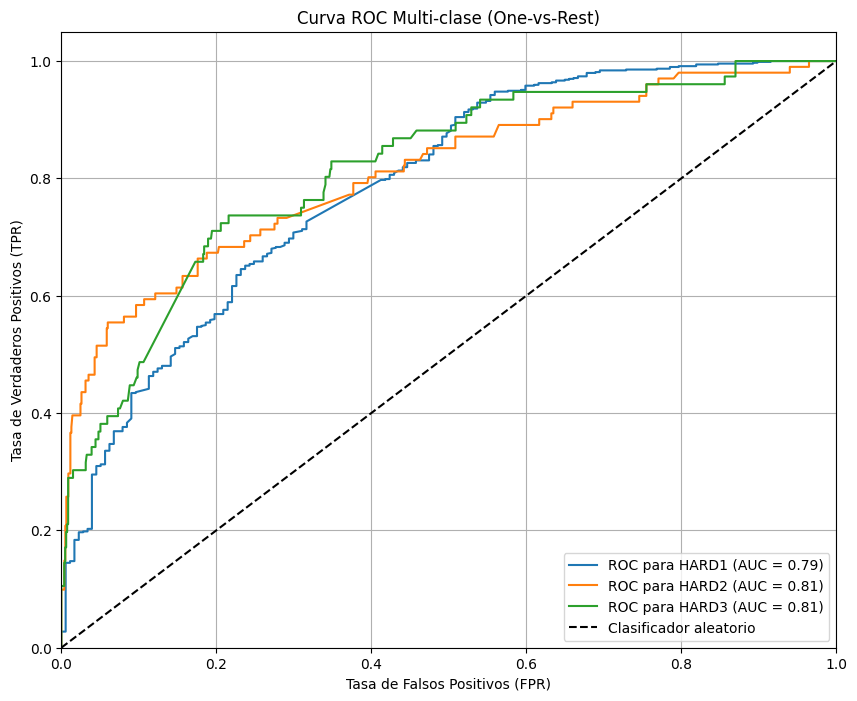

C:\Users\Aqui Creamos\AppData\Local\Temp\ipykernel_3176\3183341850.py:250: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_senses))


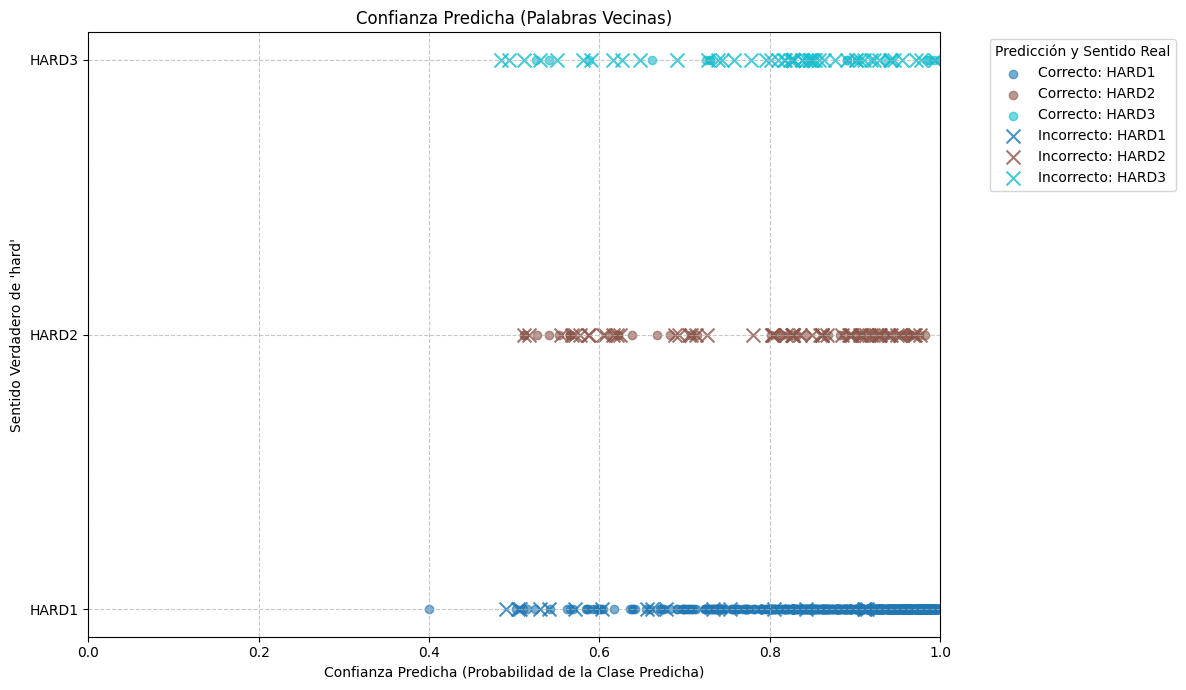


--- EVALUACIÓN: Clasificador Basado en Colocación ---
Clasificador de colocación entrenado.
Precisión (Accuracy): 0.8767

Matriz de Confusión:
[[638  28  25]
 [ 17  76   8]
 [ 11  18  47]]

Precisión (ponderada): 0.8865
Recall (ponderado): 0.8767
F1-score (ponderado): 0.8806


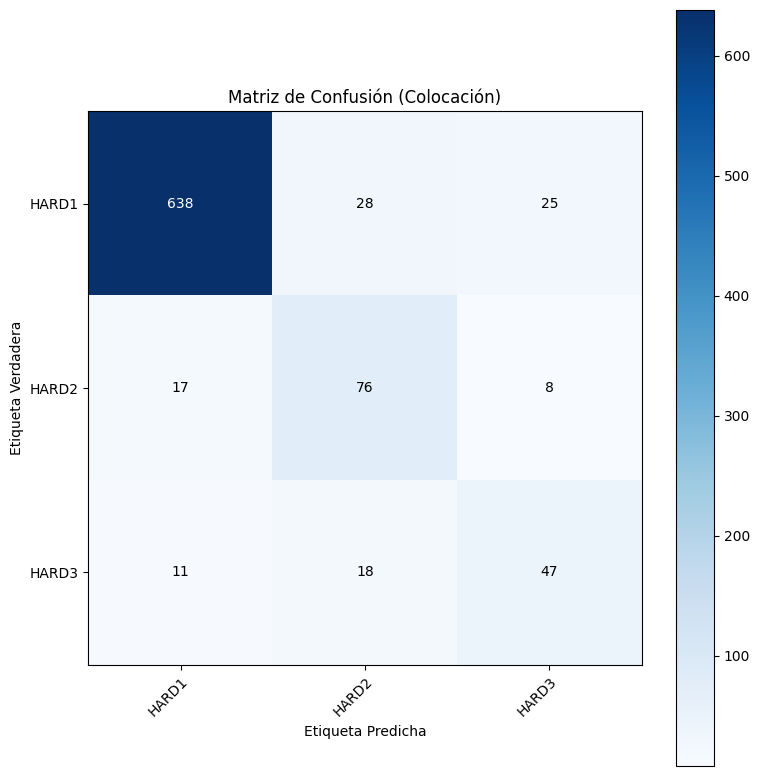


--- Curva ROC y AUC (Multiclase) ---
Nota: NLTK Naive Bayes no expone directamente las probabilidades de cada clase para ROC AUC.
Para una curva ROC completa en multiclase, se necesitaría un clasificador
que devuelva probabilidades por clase (ej., classifier.prob_classify(features).prob(class_label)).
Intentaremos simular un clasificador binario o indicar cuando no sea posible.


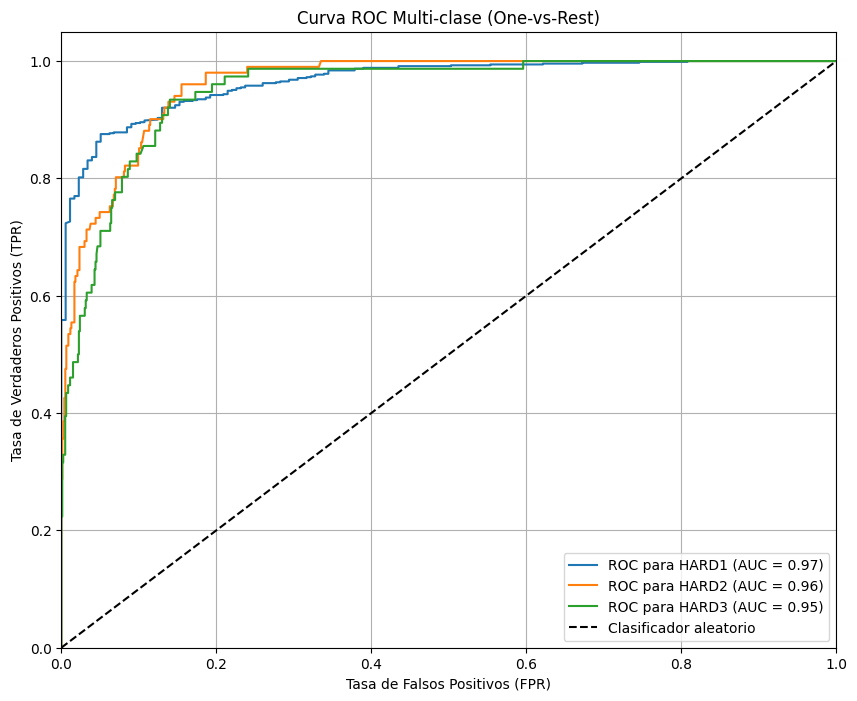

C:\Users\Aqui Creamos\AppData\Local\Temp\ipykernel_3176\3183341850.py:250: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_senses))


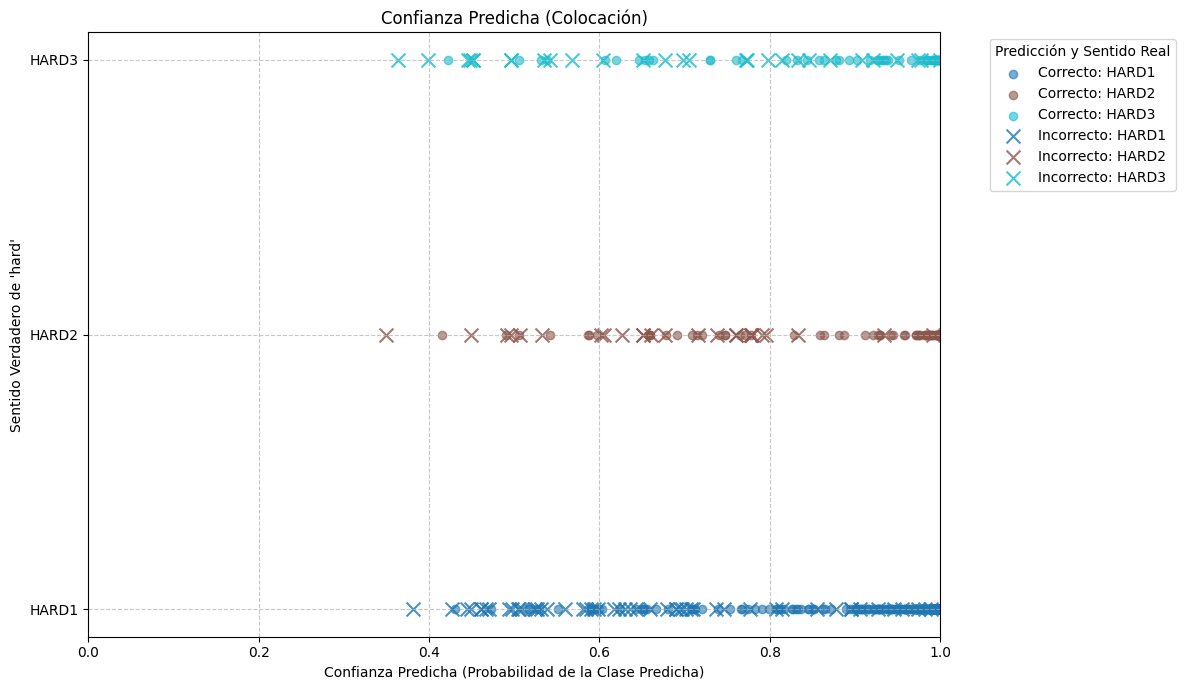

In [ ]:
import nltk
from nltk.corpus import stopwords, senseval
from nltk.classify import NaiveBayesClassifier, accuracy
import string
from collections import Counter
import random

# Para métricas de desempeño y visualización
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np # Para manejar arrays numéricos, útil para la matriz de confusión y ROC

# --- REUSO DE CÓDIGO DE LAS PARTES ANTERIORES ---

# Clase dummy para simular las instancias del corpus (si senseval.instances() no la tiene directamente)
class CustomInstance:
    def __init__(self, context, ambiguous_word, sense):
        self.context = context
        self.ambiguous_word = ambiguous_word
        self.sense = sense

# Tu conjunto de palabras a eliminar (igual al anterior)
OTHER_WORDS = ["''", "'d", "'ll", "'m", "'re", "'s", "'t", "'ve", '--', '000', '1', '2', '3', '4', '5', '6', '8', '10', '15', '30', 'I', 'F', '``',
               'also', "don'", 'n', 'one', 'said', 'say', 'says', 'u', 'us']

# Conjunto combinado de stopwords de NLTK (inglés), puntuación y tus palabras adicionales
STOPWORDS_SET = set(stopwords.words('english')).union(set(string.punctuation), set(OTHER_WORDS))

# Formas gramaticales de la palabra ambigua 'hard'
PALABRA_AMBIGUA_HARD_FORMS = {'hard', 'harder', 'hardest'}
PALABRAS_AMBIGUAS_FORMS = {
    'hard': PALABRA_AMBIGUA_HARD_FORMS,
}

def construir_vocabulario(instances, m, palabras_a_excluir):
    all_words = []
    for instance in instances:
        for item in instance.context:
            word_to_process = ''
            if isinstance(item, tuple):
                word_to_process = item[0]
            elif isinstance(item, str):
                word_to_process = item
            
            if word_to_process:
                word_lower = word_to_process.lower()
                all_words.append(word_lower)
            
    fdist = nltk.FreqDist(all_words)
    
    filtered_words_freq = Counter()
    for word, freq in fdist.items():
        if word not in palabras_a_excluir:
            filtered_words_freq[word] = freq
            
    vocabulario = [word for word, freq in filtered_words_freq.most_common(m)]
    
    return vocabulario

def extraer_caracteristicas_diccionario(instance_context, vocabulario):
    vector_caracteristicas = {}
    contexto_palabras_lower = []

    for item in instance_context:
        word_to_add = ''
        if isinstance(item, tuple):
            word_to_add = item[0]
        elif isinstance(item, str):
            word_to_add = item
        
        if word_to_add:
            contexto_palabras_lower.append(word_to_add.lower())

    for palabra_vocabulario in vocabulario:
        clave = f'contains({palabra_vocabulario})'
        if palabra_vocabulario.lower() in contexto_palabras_lower:
            vector_caracteristicas[clave] = True
        else:
            vector_caracteristicas[clave] = False
            
    return vector_caracteristicas

def extraer_caracteristicas_colocacion(instance_context, ambiguous_word_index, n=2):
    features = {}
    
    words = []
    for item in instance_context:
        word_to_add = ''
        if isinstance(item, tuple):
            word_to_add = item[0]
        elif isinstance(item, str):
            word_to_add = item
        if word_to_add:
            words.append(word_to_add.lower())
    
    for i in range(1, n + 1):
        if ambiguous_word_index - i >= 0:
            features[f'L{i}={words[ambiguous_word_index - i]}'] = True
        else:
            features[f'L{i}=<START>'] = True
            
    for i in range(1, n + 1):
        if ambiguous_word_index + i < len(words):
            features[f'R{i}={words[ambiguous_word_index + i]}'] = True
        else:
            features[f'R{i}=<END>'] = True
            
    return features

# --- FUNCIONES PARA MÉTRICAS Y VISUALIZACIÓN ---

def evaluar_clasificador(classifier, test_featureset, class_labels):
    """
    Calcula y muestra métricas de desempeño para un clasificador.

    Args:
        classifier: El clasificador NLTK entrenado.
        test_featureset (list): Lista de (características, etiqueta_verdadera) para el test.
        class_labels (list): Lista de todas las etiquetas (clases) posibles.
    """
    true_labels = [label for (features, label) in test_featureset]
    predicted_labels = [classifier.classify(features) for (features, label) in test_featureset]

    # Precisión (Accuracy)
    acc = accuracy(classifier, test_featureset)
    print(f"Precisión (Accuracy): {acc:.4f}")

    # Matriz de Confusión
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
    print("\nMatriz de Confusión:")
    print(cm)

    # Recall, Precisión, F1-score
    # 'average=weighted' es útil para multiclase desbalanceada
    precision, recall, f1_score, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, labels=class_labels, average='weighted', zero_division=0
    )
    print(f"\nPrecisión (ponderada): {precision:.4f}")
    print(f"Recall (ponderado): {recall:.4f}")
    print(f"F1-score (ponderado): {f1_score:.4f}")

    return true_labels, predicted_labels, cm, acc, precision, recall, f1_score

def visualizar_matriz_confusion(cm, class_labels, title="Matriz de Confusión"):
    """
    Visualiza la matriz de confusión.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Mostrar todas las etiquetas de clase
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_labels, yticklabels=class_labels,
           title=title,
           ylabel='Etiqueta Verdadera',
           xlabel='Etiqueta Predicha')

    # Rotar las etiquetas del eje x y alinearlas a la derecha
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Bucle para mostrar los valores en las celdas
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

def visualizar_curva_roc_multiclase(classifier, test_featureset, class_labels):
    """
    Visualiza la curva ROC para clasificación multiclase (One-vs-Rest).
    Nota: Naive Bayes en NLTK no proporciona directamente probabilidades para cada clase.
    Esto es una limitación para una curva ROC multiclase "directa".
    Podemos simularlo si es posible obtener scores por clase, o indicar la limitación.
    """
    print("\n--- Curva ROC y AUC (Multiclase) ---")
    print("Nota: NLTK Naive Bayes no expone directamente las probabilidades de cada clase para ROC AUC.")
    print("Para una curva ROC completa en multiclase, se necesitaría un clasificador")
    print("que devuelva probabilidades por clase (ej., classifier.prob_classify(features).prob(class_label)).")
    print("Intentaremos simular un clasificador binario o indicar cuando no sea posible.")

    # NLTK NaiveBayesClassifier.prob_classify() proporciona un objeto con .prob(label)
    # Esto nos permite obtener las probabilidades para cada clase.
    
    # Mapear etiquetas a índices para sklearn
    label_to_index = {label: i for i, label in enumerate(class_labels)}
    
    # Preparar datos para ROC: etiquetas verdaderas binarizadas y probabilidades predichas
    y_true_bin = np.zeros((len(test_featureset), len(class_labels)))
    y_scores = np.zeros((len(test_featureset), len(class_labels)))

    for i, (features, true_label) in enumerate(test_featureset):
        y_true_bin[i, label_to_index[true_label]] = 1
        
        prob_dist = classifier.prob_classify(features)
        for j, label in enumerate(class_labels):
            y_scores[i, j] = prob_dist.prob(label)

    # Calcular y graficar ROC para cada clase (One-vs-Rest)
    plt.figure(figsize=(10, 8))
    for i, class_label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC para {class_label} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC Multi-clase (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


def visualizar_confianza(classifier, test_featureset, class_labels, title="Gráfica de Confianza (Probabilidades Predichas)"):
    """
    Genera una gráfica de dispersión de las probabilidades predichas
    para las etiquetas verdaderas versus las etiquetas predichas.
    Esto ayuda a visualizar la "confianza" del modelo.
    """
    true_labels = []
    predicted_labels = []
    predicted_confidences = [] # Probabilidad de la clase predicha

    for features, true_label in test_featureset:
        true_labels.append(true_label)
        
        prob_dist = classifier.prob_classify(features)
        predicted_label = prob_dist.max() # La clase con la probabilidad más alta
        predicted_labels.append(predicted_label)
        predicted_confidences.append(prob_dist.prob(predicted_label))

    # Convertir a arrays para fácil manejo con numpy/matplotlib
    true_labels_np = np.array(true_labels)
    predicted_labels_np = np.array(predicted_labels)
    predicted_confidences_np = np.array(predicted_confidences)

    plt.figure(figsize=(12, 7))

    # Obtener un color para cada clase para la visualización
    unique_senses = sorted(list(set(true_labels_np)))
    colors = plt.cm.get_cmap('tab10', len(unique_senses))
    
    # Graficar puntos para instancias correctas e incorrectas
    correct_predictions = (true_labels_np == predicted_labels_np)
    incorrect_predictions = (true_labels_np != predicted_labels_np)

    # Graficar las predicciones correctas
    for i, sense in enumerate(unique_senses):
        sense_indices = np.where((true_labels_np == sense) & correct_predictions)[0]
        plt.scatter(predicted_confidences_np[sense_indices], 
                    np.full_like(predicted_confidences_np[sense_indices], i), # Y-axis will be sense index
                    color=colors(i), marker='o', alpha=0.6, label=f'Correcto: {sense}')

    # Graficar las predicciones incorrectas
    for i, sense in enumerate(unique_senses):
        sense_indices = np.where((true_labels_np == sense) & incorrect_predictions)[0]
        plt.scatter(predicted_confidences_np[sense_indices], 
                    np.full_like(predicted_confidences_np[sense_indices], i),
                    color=colors(i), marker='x', alpha=0.8, label=f'Incorrecto: {sense}', s=100) # 'x' para errores

    plt.yticks(np.arange(len(unique_senses)), unique_senses) # Poner nombres de sentidos en el eje Y
    plt.xlabel("Confianza Predicha (Probabilidad de la Clase Predicha)")
    plt.ylabel("Sentido Verdadero de 'hard'")
    plt.title(title)
    plt.xlim(0, 1) # La confianza va de 0 a 1
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title="Predicción y Sentido Real", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- PROCESO PRINCIPAL DE ENTRENAMIENTO Y EVALUACIÓN ---

print("--- Desambiguación de la palabra 'hard' ---")

# 1. Cargar las instancias de 'hard' del corpus Senseval 2
hard_instances = senseval.instances('hard.pos')
print(f"Total de instancias para 'hard' cargadas: {len(hard_instances)}")

# 2. Preparar los datos para el entrenamiento y test
senses = sorted(list(set(inst.senses[0] for inst in hard_instances if inst.senses))) # Obtener y ordenar sentidos
print(f"Sentidos de 'hard' encontrados: {senses}")

instances_by_sense = {sense: [] for sense in senses}
for inst in hard_instances:
    if inst.senses:
        instances_by_sense[inst.senses[0]].append(inst)

training_set = []
test_set = []

for sense, instances in instances_by_sense.items():
    random.shuffle(instances)
    split_point = int(0.8 * len(instances))
    training_set.extend(instances[:split_point])
    test_set.extend(instances[split_point:])

random.shuffle(training_set)
random.shuffle(test_set)

print(f"Tamaño del conjunto de entrenamiento: {len(training_set)}")
print(f"Tamaño del conjunto de prueba: {len(test_set)}")

# 3. Conjunto de palabras a excluir para la construcción del vocabulario
words_to_exclude_for_vocab = set(STOPWORDS_SET).union(PALABRA_AMBIGUA_HARD_FORMS)

# 4. Construir el vocabulario de 250 palabras más frecuentes para el clasificador de palabras vecinas
m_vocab_size = 250
vocabulario_vecinas = construir_vocabulario(training_set, m_vocab_size, words_to_exclude_for_vocab)
print(f"\nVocabulario de palabras vecinas (top {m_vocab_size} palabras):\n{vocabulario_vecinas[:10]}... (mostrando las primeras 10)")

# --- Clasificador Basado en Palabras Vecinas ---
print("\n" + "="*50)
print("--- EVALUACIÓN: Clasificador Basado en Palabras Vecinas ---")
print("="*50)

training_featureset_vecinas = [
    (extraer_caracteristicas_diccionario(inst.context, vocabulario_vecinas), inst.senses[0])
    for inst in training_set
]

test_featureset_vecinas = [
    (extraer_caracteristicas_diccionario(inst.context, vocabulario_vecinas), inst.senses[0])
    for inst in test_set
]

classifier_vecinas = NaiveBayesClassifier.train(training_featureset_vecinas)
print(f"Clasificador de palabras vecinas entrenado.")

true_labels_vecinas, predicted_labels_vecinas, cm_vecinas, acc_vecinas, prec_vecinas, rec_vecinas, f1_vecinas = \
    evaluar_clasificador(classifier_vecinas, test_featureset_vecinas, senses)

# Visualizaciones para el clasificador de Palabras Vecinas
visualizar_matriz_confusion(cm_vecinas, senses, title="Matriz de Confusión (Palabras Vecinas)")
visualizar_curva_roc_multiclase(classifier_vecinas, test_featureset_vecinas, senses)
visualizar_confianza(classifier_vecinas, test_featureset_vecinas, senses, title="Confianza Predicha (Palabras Vecinas)")


# --- Clasificador Basado en Características de Colocación ---
print("\n" + "="*50)
print("--- EVALUACIÓN: Clasificador Basado en Colocación ---")
print("="*50)

n_colocacion = 2

training_featureset_colocacion = [
    (extraer_caracteristicas_colocacion(inst.context, inst.position, n_colocacion), inst.senses[0])
    for inst in training_set
]

test_featureset_colocacion = [
    (extraer_caracteristicas_colocacion(inst.context, inst.position, n_colocacion), inst.senses[0])
    for inst in test_set
]

classifier_colocacion = NaiveBayesClassifier.train(training_featureset_colocacion)
print(f"Clasificador de colocación entrenado.")

true_labels_colocacion, predicted_labels_colocacion, cm_colocacion, acc_colocacion, prec_colocacion, rec_colocacion, f1_colocacion = \
    evaluar_clasificador(classifier_colocacion, test_featureset_colocacion, senses)

# Visualizaciones para el clasificador de Colocación
visualizar_matriz_confusion(cm_colocacion, senses, title="Matriz de Confusión (Colocación)")
visualizar_curva_roc_multiclase(classifier_colocacion, test_featureset_colocacion, senses)
visualizar_confianza(classifier_colocacion, test_featureset_colocacion, senses, title="Confianza Predicha (Colocación)")